In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

<ipython-input-2-ac09909db896>:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [6]:
# ! pip install tokenizer #<---- Unk
# ! pip install tokenizers #<--- HugginFace
# ! pip install pandas
# ! pip install matplotlib
# ! pip install seaborn

In [3]:
from pathlib import Path
from tokenizers import ByteLevelBPETokenizer #HugginFace
import pandas as pd
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:.2f}'.format

In [4]:
#export
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import functools

In [5]:
from collections import Counter

In [1]:
sns.set_theme(style="darkgrid")

NameError: name 'sns' is not defined

# Exploratory Data Code Analysis

In [7]:
def param_default():
    corpus = 'fm_fc_ms_ff' #<-- Scope
    data_path = Path('../athena-datasets/' + corpus + '/')
    data_path_raw = Path('../athena-datasets/' + corpus + '/raw/')
    tokenizer_path = Path('../tokenizer/')
    return {
        'bpe_path' : tokenizer_path / 'universal_tokenizer/universal_tokenizer/roberta_aug_spaces',
        'eval_raw': [data_path_raw / 'eval/input.methods.txt',
                        data_path_raw / 'eval/output.tests.txt'],
        'test_raw': [data_path_raw / 'test/input.methods.txt', 
                        data_path_raw / 'test/output.tests.txt'],
        'train_raw': [data_path_raw / 'train/input.methods.txt', 
                        data_path_raw / 'train/output.tests.txt'],
        'data_labels' : ['eval_raw','test_raw','train_raw'],
        'output_pandas' : data_path / 'pandas/'
    }

In [8]:
params = param_default()

In [9]:
params['eval_raw']

[PosixPath('../athena-datasets/fm_fc_ms_ff/raw/eval/input.methods.txt'),
 PosixPath('../athena-datasets/fm_fc_ms_ff/raw/eval/output.tests.txt')]

## Universal Tokenizer

In [10]:
def load_tokenizer( bpe_path ):
    return ByteLevelBPETokenizer(str(bpe_path)+'-vocab.json',str(bpe_path)+'-merges.txt')

In [14]:
#bpe_path = '/tufanodata/work/unit-test-gen/code/universal_tokenizer/universal_tokenizer/roberta_aug_spaces'
tokenizer = load_tokenizer(params['bpe_path'])
tokenizer

Tokenizer(vocabulary_size=50342, model=ByteLevelBPE, add_prefix_space=False, lowercase=False, dropout=None, unicode_normalizer=None, continuing_subword_prefix=None, end_of_word_suffix=None, trim_offsets=False)

## Generative Functions

In [11]:
def pretty_print_test(test):
    print('Working on test number', test['id'])
    print('The focal method being tested is:\n',prettify_java(test['source']))
    print('\nThe generated unit test is:\n',prettify_java(test['top-prediciton']))
    print('\nThe ground truth unit test is:\n',prettify_java(test['target']),'\n-----------------------------------------------------------------\n')

In [12]:
def prettify_java(minified_java):
    "tries to undo Michele's minification. Works decently, although for loops and sets get newlines inserted, and there are no empty lines or comments"
    minified_java = minified_java.replace('{','{\n').replace('}','}\n').replace(';',';\n')
    num_indents = 0
    pretty_java = ''
    for line in minified_java.splitlines():
        if line.lstrip().startswith('}'):
            num_indents -= 1
        pretty_java += num_indents*'    '+line+'\n'
        if line.endswith('{'):
            num_indents += 1
        if line.endswith('}') and not line.lstrip().startswith('}'):
            num_indents -= 1
    return pretty_java

In [13]:
def minify(java_code):
    return ' '.join(java_code.split())

In [15]:
#export
def method_size_vector( method_vector ):
    '''Return the size of the tokens for a give method based on id
        Assuming that method_vector is an array of tokens
    '''
    input_ids = [ len(mtd) for mtd in method_vector ]
    return input_ids

In [16]:
def super_set_code():
    data = {}
    for label in params['data_labels']:
        for val,path_data in enumerate(params[ label ]):
            df = pd.read_csv( path_data, sep="\n", header=None, names=[label+str(val)]) #reading file
            df[label+'_bpe'+str(val)] = [ enc.tokens for enc in tokenizer.encode_batch( df[label+str(val)].values ) ] #bpe
            df['method_size'+str(val)] = method_size_vector( df[label+'_bpe'+str(val)].values ) #counting tokens
            data[label+str(val)] =  df  
        #data[-1].columns = [ label ]
    return data

In [44]:
super_data = super_set_code()

In [45]:
super_data.keys()

dict_keys(['eval_raw0', 'eval_raw1', 'test_raw0', 'test_raw1', 'train_raw0', 'train_raw1'])

In [46]:
super_data['eval_raw0'].head(1)

,eval_raw0,eval_raw_bpe0,method_size0
0,RosetteAbstractProcessor extends AbstractProce...,"[Ros, ette, Abstract, Process, or, Ġextends, Ġ...",220


In [47]:
#tst
tokenizer.encode( super_data['eval_raw0'].eval_raw0.values[0] )

Encoding(num_tokens=220, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [17]:
# [Checkpoint] Saving
def checkpoint_1(df_dict):
    for key in df_dict.keys():
        df = df_dict[key]
        df.to_json( params['output_pandas'] / (key +'.json') ) #serialization
    pass

In [50]:
checkpoint_1( super_data ) #<--- Data Checkpoint!

In [19]:
# Loading Json Sets
def load_checkpoint_1():
    super_df = {}
    for label in params['data_labels']:
        for val, _ in enumerate(params[ label ]):
            super_df[ label+str(val) ] = pd.read_json( params['output_pandas'] / (label+str(val) +'.json')  )
            print("read:",label+str(val))
    return super_df

# Method Size Distribution

In [20]:
super_data = load_checkpoint_1()

read: eval_raw0
read: eval_raw1
read: test_raw0
read: test_raw1
read: train_raw0
read: train_raw1


In [21]:
super_data.keys()

dict_keys(['eval_raw0', 'eval_raw1', 'test_raw0', 'test_raw1', 'train_raw0', 'train_raw1'])

In [22]:
super_data['eval_raw1'].head()

,eval_raw1,eval_raw_bpe1,method_size1
0,@Test(expected = ElasticsearchException.class)...,"[@, Test, (, expected, Ġ=, ĠElastic, search, E...",123
1,@Test public void testFormatToUserFriendlyForm...,"[@, Test, Ġpublic, Ġvoid, Ġtest, Format, To, U...",51
2,@Test public void testTESThasDescription() { s...,"[@, Test, Ġpublic, Ġvoid, Ġtest, T, ES, Th, as...",36
3,@Test public void testNormalizeOutliers(){ ass...,"[@, Test, Ġpublic, Ġvoid, Ġtest, Normal, ize, ...",236
4,@Test public void evaluateAggregateFunctions()...,"[@, Test, Ġpublic, Ġvoid, Ġevaluate, Agg, rega...",221


In [23]:
def method_size_df(super_data_):
    df_code = {}
    for label in params['data_labels']:
        df = pd.concat( [super_data_[label+'0'], super_data_[label+'1']], axis=1 ) #TODO Generalize the number Hardcoded paths
        df_code[label]  = df[['method_size0','method_size1']]
    return df_code

In [24]:
df_method_size = method_size_df(super_data)

In [77]:
for key in df_method_size:
    print(key)
    print(df_method_size[key].describe())
    print(df_method_size[key].median())

eval_raw
       method_size0  method_size1
count      78534.00      78534.00
mean         470.26        162.11
std          853.22        226.00
min           16.00          7.00
25%          145.00         60.00
50%          254.00        105.00
75%          477.00        188.00
max        24649.00      23250.00
method_size0   254.00
method_size1   105.00
dtype: float64
test_raw
       method_size0  method_size1
count      78388.00      78388.00
mean         423.42        159.11
std          653.26        450.52
min            8.00          7.00
25%          143.00         61.00
50%          248.00        102.00
75%          446.00        179.00
max        31638.00      62933.00
method_size0   248.00
method_size1   102.00
dtype: float64
train_raw
       method_size0  method_size1
count     624022.00     624022.00
mean         409.76        156.49
std          653.88        259.40
min           10.00          6.00
25%          144.00         61.00
50%          246.00        103.00
75% 

In [76]:
#THRS = data.method.mean()
#THRS = df_eval.method_size1.quantile(q=0.90)

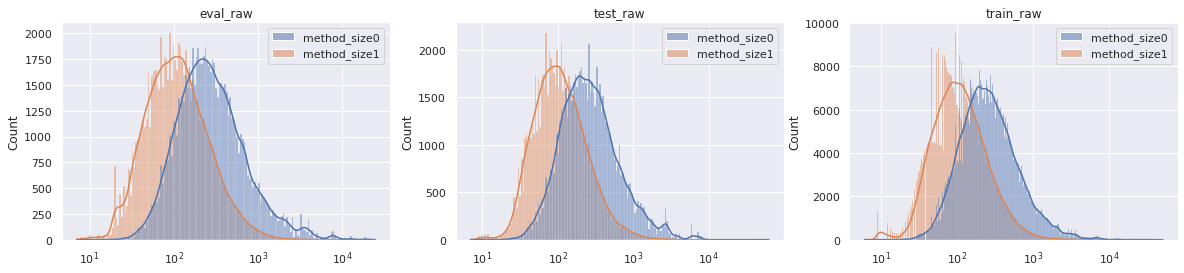

In [78]:
fig, axs = plt.subplots( figsize=(20,4), ncols=3 )
for i,key in enumerate(df_method_size):
    #plt.figure(i)
    sns.histplot(data=df_method_size[key], kde=True, log_scale=True, ax=axs[i]).set_title(key)

In [110]:
#sns.histplot(data=df_eval[df_eval.method_size1 <= THRS], x="method_size1", kde=True)

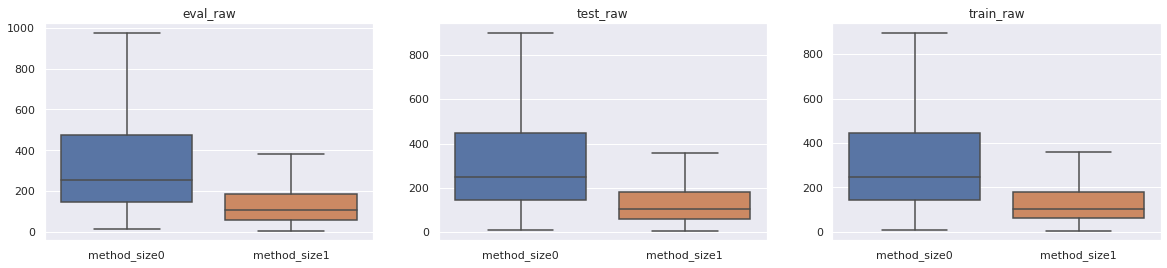

In [79]:
fig, axs = plt.subplots( figsize=(20,4), ncols=3 )
for i,key in enumerate(df_method_size):
    #plt.figure(i)
    sns.boxplot(data=df_method_size[key], showfliers=False,ax=axs[i]).set_title(key)

# Token Distribution

In [28]:
#export
def token_distribution( method_vector ):
    '''Return a Counter Object'''
    cnt = Counter()
    for method in method_vector:
        for token in method:
            cnt[token] += 1
    return cnt

In [29]:
super_data.keys()

dict_keys(['eval_raw0', 'eval_raw1', 'test_raw0', 'test_raw1', 'train_raw0', 'train_raw1'])

In [30]:
def token_distribution_dict(super_data_):
    dct_control = {}
    for label in params['data_labels']:
        dct_control[label] = [ token_distribution( super_data_[label+'0'][label+'_bpe0'].values ), token_distribution( super_data_[label+'1'][label+'_bpe1'].values )]
    return dct_control

In [31]:
#TODO Save the countings
dct_control = token_distribution_dict( super_data ) # [WARNING!] Time consuming

In [95]:
def count_by_taxonomy( dct_control, k_token = ['assert'], stringent = False, flag = False ):
    "Counting the token across BPEs"
    dict_most_k_tok = dict.fromkeys( k_token, 0 )
    for k in dct_control.keys():
        for k_tok in k_token:
            if stringent:
                if k_tok == k:
                    dict_most_k_tok[k_tok] +=  dct_control[ k ]
                    if flag:
                        print( k +" : "+ str(dct_control[ k ]) )
            else:
                tmp = 'Ġ'+ k_tok
                #if k_tok in k:
                if k_tok == k or tmp == k:    
                    dict_most_k_tok[k_tok] +=  dct_control[ k ]
                    if flag:
                        print( k +" : "+ str(dct_control[ k ]) )
                
    return Counter(dict_most_k_tok)

In [68]:
def count_by_taxonomy_list(list_dct_control, k_token = ['assert'], stringent = False ):
    ''''Flatting function for Source/Target datasets'''
    return [ dict( count_by_taxonomy( dct_control, k_token , stringent ) ) for dct_control in list_dct_control]

In [102]:
def print_token_distribution( dict_most, ax, log = False, label=['Control'], title='' ):

    for count, label_ in enumerate(label):
        ax.bar(dict_most[count].keys(), dict_most[count].values(), width=(0.3*((-1)**count)),  align='edge', alpha=.6, label=label_)
    
    ax.set_ylabel('N. Tokens')
    ax.set_title('Token by taxonomy '+ title)
    ax.legend()

    if log:
        ax.set_yscale("log")

    #plt.show()

## Most Popular

In [43]:
TOK = 10
dict_most = {}

for dct_cnt in dct_control:
    dict_most[dct_cnt] = [
        dict(dct_control[dct_cnt][0].most_common( TOK )) ,
        dict(dct_control[dct_cnt][1].most_common( TOK ))    
    ] #<---Hyperparameter

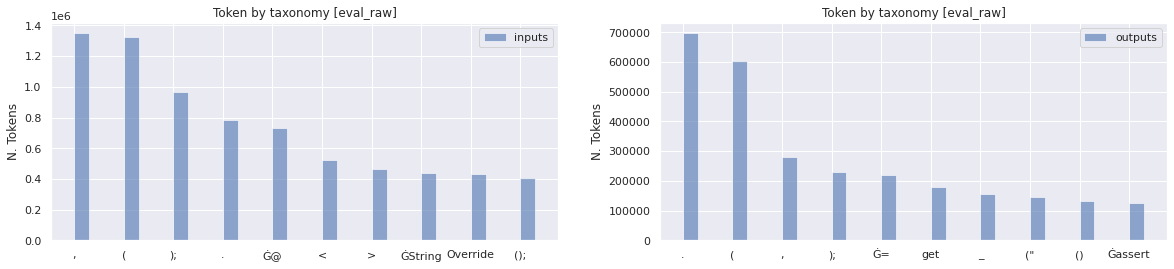

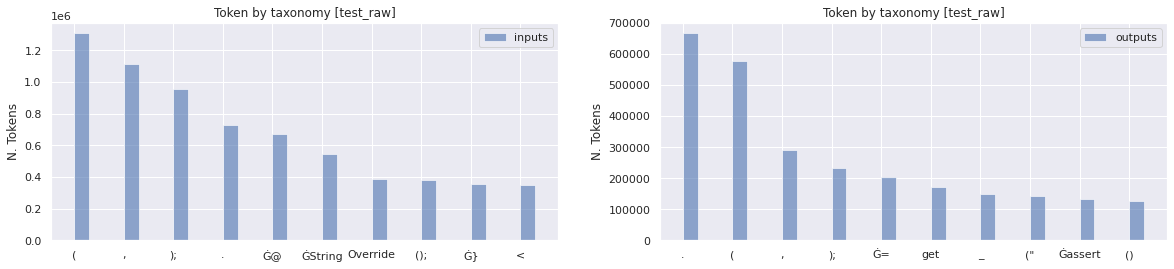

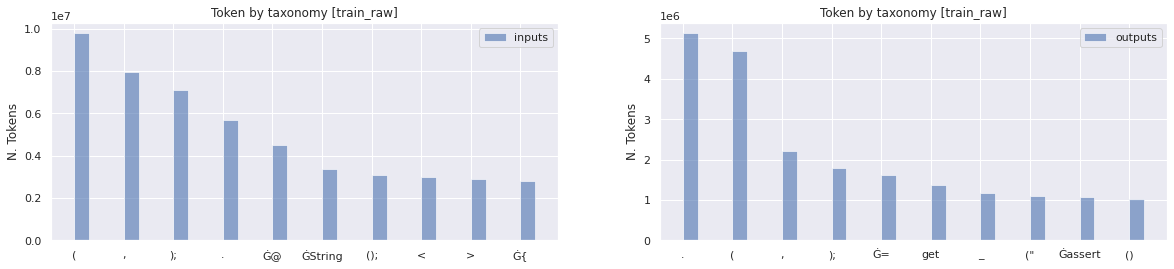

In [75]:
#printing most popular tokens
for key in dict_most:
    fig, axs = plt.subplots( figsize=(20,4), ncols=2 )
    print_token_distribution( [dict_most[key][0]], ax=axs[0], TOK=TOK, label=['inputs'], log=False, title= '['+key+']')
    print_token_distribution( [dict_most[key][1]], ax=axs[1], TOK=TOK, label=['outputs'], log=False, title= '['+key+']')

## Special Tokens

In [61]:
proposed_token = ['assert','private','public','abstract','static','if','else','for']

In [69]:
focused_tokens_non = { split :  count_by_taxonomy_list( dct_control[split], k_token = proposed_token )  for split in dct_control}

Ġpublic : 74951
Ġif : 121810
Ġfor : 31690
Ġstatic : 326130
Ġprivate : 13613
Ġelse : 32562
for : 1756
Ġabstract : 4408
Ġassert : 1324
static : 51
if : 2763
else : 641
public : 473
private : 140
assert : 222
Ġpublic : 74597
Ġassert : 127151
if : 1058
for : 1941
Ġfor : 6613
assert : 41381
Ġif : 3166
Ġelse : 864
static : 134
else : 99
public : 239
Ġabstract : 238
Ġprivate : 549
private : 214
Ġstatic : 171
Ġpublic : 76347
Ġstatic : 321229
Ġif : 132416
Ġelse : 31483
Ġprivate : 14301
public : 278
private : 301
Ġfor : 29161
if : 3888
for : 2401
Ġabstract : 5562
else : 363
Ġassert : 2138
static : 280
assert : 408
Ġpublic : 78445
Ġassert : 132251
if : 1110
private : 329
public : 376
Ġfor : 6152
Ġif : 2884
Ġelse : 835
assert : 34718
Ġstatic : 174
static : 93
for : 1938
Ġprivate : 364
else : 49
Ġabstract : 153
Ġpublic : 599563
Ġif : 943072
Ġelse : 241066
Ġfor : 218163
else : 2722
Ġstatic : 2578818
Ġprivate : 105628
Ġassert : 10443
for : 18392
Ġabstract : 33066
public : 2774
assert : 3168
static : 

In [70]:
focused_tokens = { split :  count_by_taxonomy_list( dct_control[split], k_token = proposed_token , stringent=True )  for split in dct_control}
#dict( count_by_taxonomy( dct_control, k_token = proposed_token, stringent=True ) )

for : 1756
static : 51
if : 2763
else : 641
public : 473
private : 140
assert : 222
if : 1058
for : 1941
assert : 41381
static : 134
else : 99
public : 239
private : 214
public : 278
private : 301
if : 3888
for : 2401
else : 363
static : 280
assert : 408
if : 1110
private : 329
public : 376
assert : 34718
static : 93
for : 1938
else : 49
else : 2722
for : 18392
public : 2774
assert : 3168
static : 2217
if : 25711
private : 1194
assert : 236556
if : 9502
for : 16323
public : 3035
else : 525
static : 1023
private : 1747


In [71]:
focused_tokens_non

{'eval_raw': [{'assert': 1546,
   'private': 13753,
   'public': 75424,
   'abstract': 4408,
   'static': 326181,
   'if': 124573,
   'else': 33203,
   'for': 33446},
  {'assert': 168532,
   'private': 763,
   'public': 74836,
   'abstract': 238,
   'static': 305,
   'if': 4224,
   'else': 963,
   'for': 8554}],
 'test_raw': [{'assert': 2546,
   'private': 14602,
   'public': 76625,
   'abstract': 5562,
   'static': 321509,
   'if': 136304,
   'else': 31846,
   'for': 31562},
  {'assert': 166969,
   'private': 693,
   'public': 78821,
   'abstract': 153,
   'static': 267,
   'if': 3994,
   'else': 884,
   'for': 8090}],
 'train_raw': [{'assert': 13611,
   'private': 106822,
   'public': 602337,
   'abstract': 33066,
   'static': 2581035,
   'if': 968783,
   'else': 243788,
   'for': 236555},
  {'assert': 1313958,
   'private': 3698,
   'public': 616364,
   'abstract': 873,
   'static': 2056,
   'if': 32887,
   'else': 8252,
   'for': 69305}]}

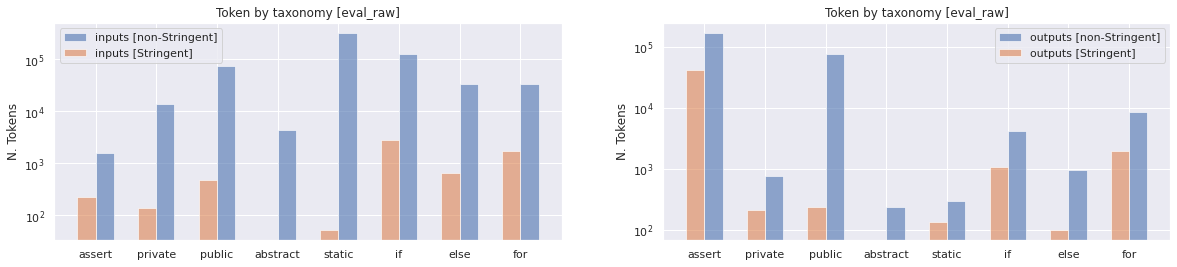

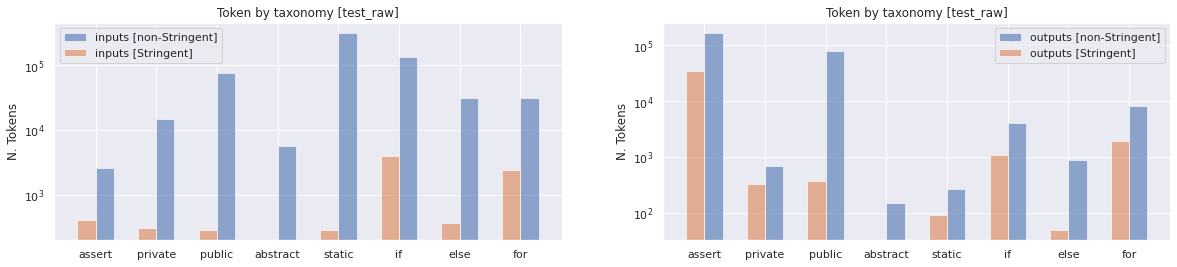

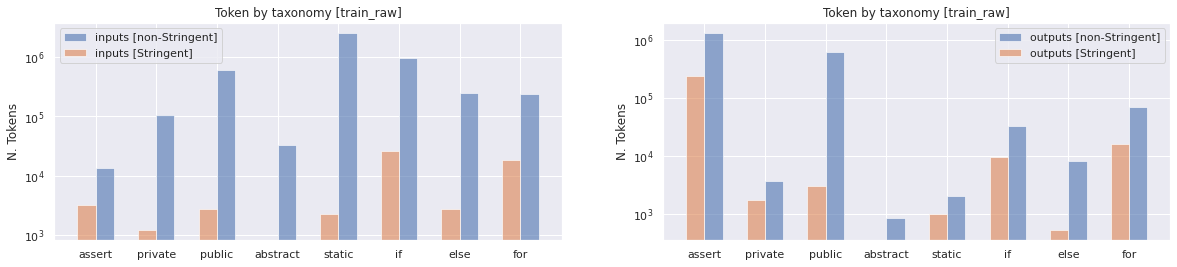

In [93]:
#printing selected (interesting) tokens
#print_token_distribution( [focused_tokens_non,focused_tokens] , label=['non-Stringent','Stringent'], log=True )

#printing most popular tokens
for key in params['data_labels']:
    fig, axs = plt.subplots( figsize=(20,4), ncols=2 )
    print_token_distribution( [focused_tokens_non[key][0],focused_tokens[key][0]], ax=axs[0],  label=['inputs [non-Stringent]','inputs [Stringent]'], log=True, title='['+key+']' )
    print_token_distribution( [focused_tokens_non[key][1],focused_tokens[key][1]], ax=axs[1],  label=['outputs [non-Stringent]', 'outputs [Stringent]'], log=True, title='['+key+']' )

## Taxonomy Countings

In [80]:
#export
def token_taxonomy() -> dict:
    return {
  "blocks": {
    "<{>": "{",
    "<}>": "}",
    "<[>": "[",
    "<]>": "]",
    "<(>": "(",
    "<)>": ")",
    "<;>": ";",
    "<return>": "return"
  },
  "exceptions": {
    "<catch>": "catch",
    "<try>": "try",
    "<finally>": "finally",
    "<throw>": "throw",
    "<throws>": "throws"
  },
  "oop": {
    "<class>": "class",
    "<instanceof>": "instanceof",
    "<interface>": "interface",
    "<private>": "private",
    "<protected>": "protected",
    "<public>": "public",
    "<abstract>": "abstract",
    "<extends>": "extends",
    "<package>": "package",
    "<this>": "this",
    "<implements>": "implements",
    "<import>": "import",
    "<new>": "new",
    "<super>": "super"
  },
  "tests": {
    "<assert>": "assert"
  },
  "declarations": {
    "<native>": "native",
    "<static>": "static",
    "<synchronized>": "synchronized",
    "<transient>": "transient",
    "<volatile>": "volatile",
    "<void>": "void",
    "<final>": "final",
    "<enum>": "enum"
  },
  "conditionals": {
    "<else>": "else",
    "<if>": "if",
    "<switch>": "switch",
    "<case>": "case",
    "<default>": "default"
  },
  "loops": {
    "<break>": "break",
    "<do>": "do",
    "<for>": "for",
    "<while>": "while",
    "<continue>": "continue"
  },
  "operators": {
    "<=>": "=",
    "<+>": "+",
    "<->": "-",
    "<*>": "*",
    "</>": "/",
    "<%>": "%",
    "<++>": "++",
    "<-->": "--",
    "<!>": "!",
    "<==>": "==",
    "<!=>": "!=",
    "<greater_equal>": ">=",
    "<lesser_equal>": "<=",
    "<&&>": "&&",
    "<||>": "||",
    "<?>": "?",
    "<:>": ":",
    "<~>": "~",
    "<double_lesser>": "<<",
    "<double_greater>": ">>",
    "<triple_greater>": ">>>",
    "<&>": "&",
    "<^>": "^",
    "<|>": "|"
  },
  "datatypes": {
    "<byte>": "byte",
    "<char>": "char",
    "<float>": "float",
    "<boolean>": "boolean",
    "<double>": "double",
    "<int>": "int",
    "<long>": "long",
    "<short>": "short",
    "<strictfp>": "strictfp"
  },
  "extra_tokens": {
    "<@>": "@",
    "<...>": "...",
    "<null>": "null",
    "<true>": "true",
    "<false>": "false",
    "<n>": "\n"
  }
}

In [81]:
tkn_taxonomy = token_taxonomy()

In [86]:
tkn_taxonomy['extra_tokens'].values()

dict_values(['@', '...', 'null', 'true', 'false', '\n'])

In [87]:
dct_control.keys()

dict_keys(['eval_raw', 'test_raw', 'train_raw'])

In [96]:
def taxonomy_counting_v1( tkn_taxonomy, dct_control, stringent=False ):
    ''''Hardcoded version of taxonomy counting'''
    dict_tokens = {}
    for split in dct_control:
        to_flat_tax_dict = { tax :  count_by_taxonomy_list( dct_control[split], k_token = tkn_taxonomy[tax].values() , stringent=stringent )  for tax in tkn_taxonomy }
        to_flat_tax_dict = { tax : [ functools.reduce(lambda a, b: a+b, list_dict.values() ) for list_dict in to_flat_tax_dict[tax] ] for tax in to_flat_tax_dict }
        dict_tokens[split] = [ 
                { tax: to_flat_tax_dict[tax][0] for tax in to_flat_tax_dict }, #Hardcoded Input
                { tax: to_flat_tax_dict[tax][1] for tax in to_flat_tax_dict } #Hardcoded Output
            ]
    return dict_tokens

In [99]:
flat_dict_foc_tax_non = taxonomy_counting_v1( tkn_taxonomy, dct_control, stringent=False )
flat_dict_foc_tax_str = taxonomy_counting_v1( tkn_taxonomy, dct_control, stringent=True )

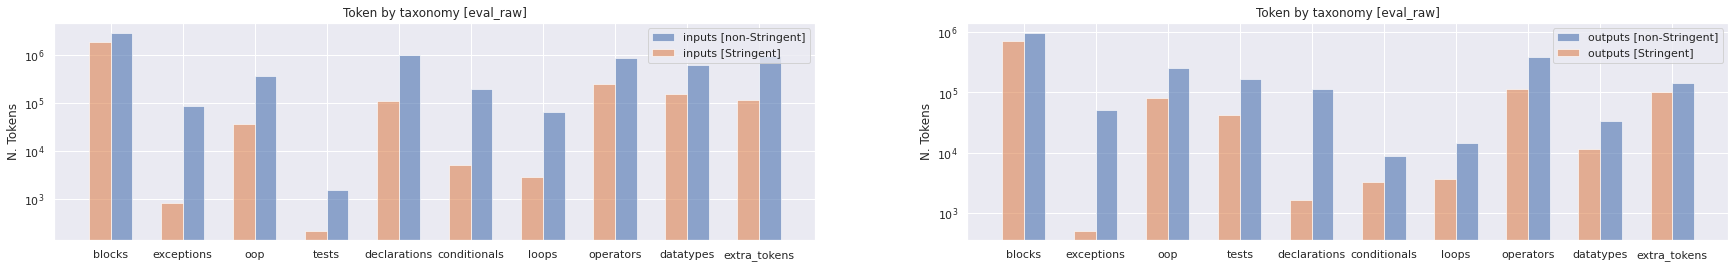

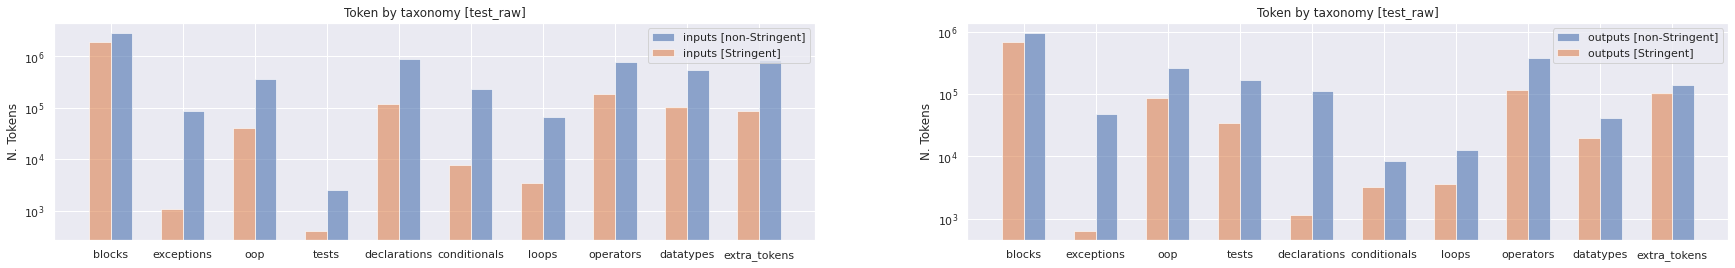

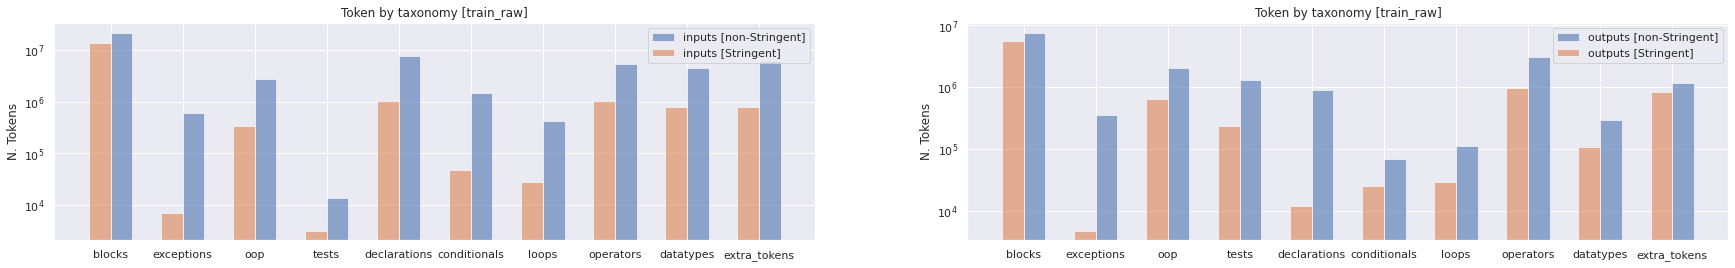

In [104]:
#flat_dict_foc_tax_str
#print_token_distribution( [flat_dict_foc_tax_non,flat_dict_foc_tax] , label=['non-Stringent','Stringent'], log=True, TOK=15 )

for key in params['data_labels']:
    fig, axs = plt.subplots( figsize=(30,4), ncols=2 )
    print_token_distribution( [flat_dict_foc_tax_non[key][0],flat_dict_foc_tax_str[key][0]], ax=axs[0],  label=['inputs [non-Stringent]','inputs [Stringent]'], log=True, title='['+key+']' )
    print_token_distribution( [flat_dict_foc_tax_non[key][1],flat_dict_foc_tax_str[key][1]], ax=axs[1],  label=['outputs [non-Stringent]', 'outputs [Stringent]'], log=True, title='['+key+']' )